In [1]:
import numpy as np
import pandas as pd
import gc
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import random

import warnings 
warnings.filterwarnings('ignore')

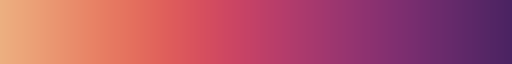

In [2]:
random.seed(42)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
sns.color_palette("flare", as_cmap=True)

# Loding Data

In [3]:
dataframe = pd.read_feather('../input/amexfeather/train_data.ftr')
dataframe = dataframe.groupby('customer_ID').tail(1).set_index('customer_ID')

# limit for testing
dataframe = dataframe.head(1000)

# Missing values

In [4]:
null_vals = dataframe.isna().sum().sort_values(ascending=False)
null_vals[null_vals > 0 ]

D_87     997
D_88     997
D_111    997
D_110    997
B_39     995
        ... 
D_84       1
D_52       1
B_25       1
D_72       1
B_15       1
Length: 90, dtype: int64

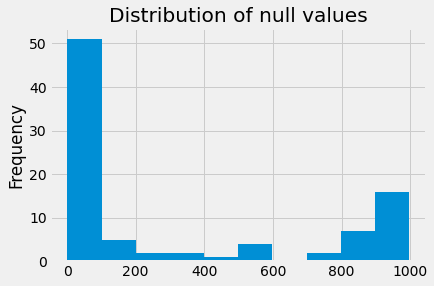

In [5]:
plt.title("Distribution of null values")
null_vals[null_vals > 0 ].plot(kind = 'hist');

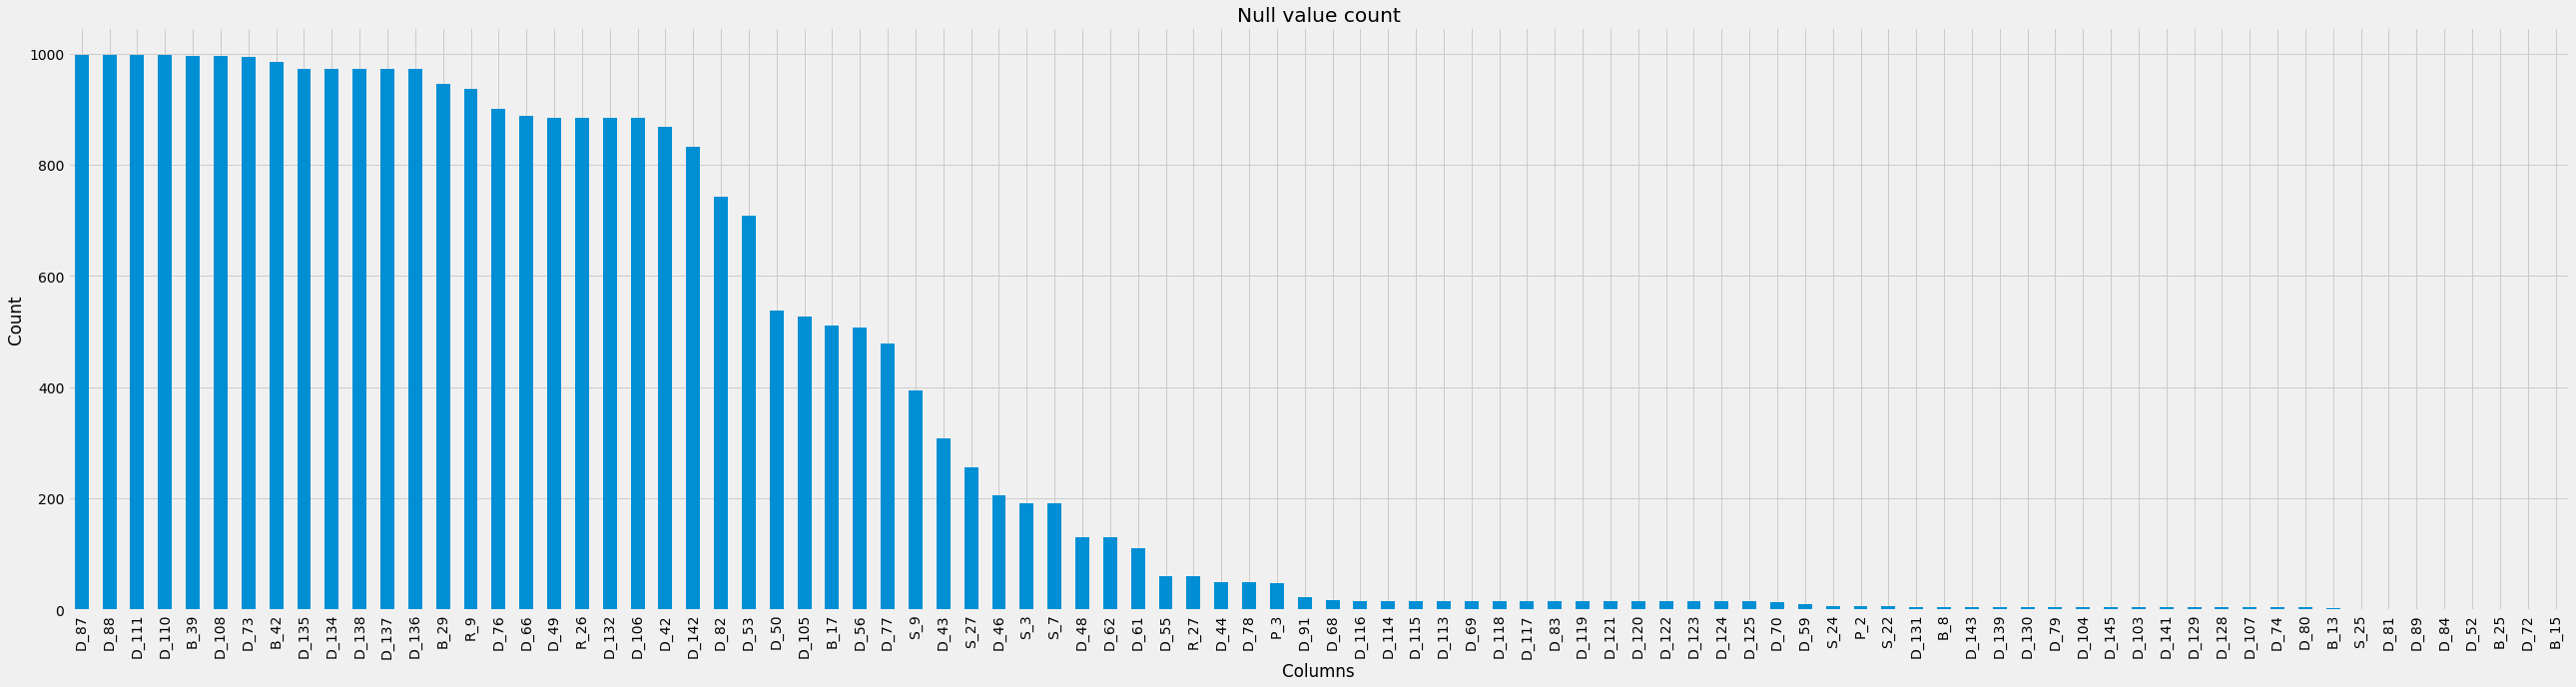

In [6]:
plt.figure(figsize=(40,10))
plt.title("Null value count")
plt.xlabel("Columns")
plt.ylabel("Count")
null_vals[null_vals > 0 ].plot(kind="bar");

# Target Imbalance

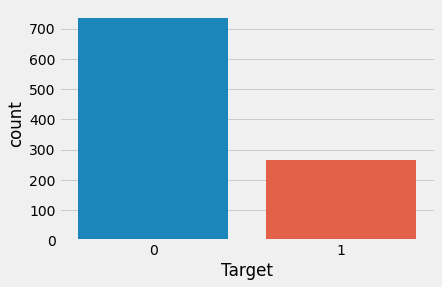

In [7]:
sns.countplot(
    dataframe["target"].values,
).set_xlabel("Target");

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers


In [9]:

#change datetime to timestamp
dataframe['S_2'] = dataframe[['S_2']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)

In [10]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 800 samples for training and 200 for validation


In [11]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

2022-08-22 21:10:49.197811: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)


Input: {'S_2': <tf.Tensor: shape=(), dtype=int64, numpy=1522368000>, 'P_2': <tf.Tensor: shape=(), dtype=float16, numpy=0.6797>, 'D_39': <tf.Tensor: shape=(), dtype=float16, numpy=0.148>, 'B_1': <tf.Tensor: shape=(), dtype=float16, numpy=0.05103>, 'B_2': <tf.Tensor: shape=(), dtype=float16, numpy=0.1057>, 'R_1': <tf.Tensor: shape=(), dtype=float16, numpy=0.00974>, 'S_3': <tf.Tensor: shape=(), dtype=float16, numpy=0.1048>, 'D_41': <tf.Tensor: shape=(), dtype=float16, numpy=0.00244>, 'B_3': <tf.Tensor: shape=(), dtype=float16, numpy=0.1935>, 'D_42': <tf.Tensor: shape=(), dtype=float16, numpy=nan>, 'D_43': <tf.Tensor: shape=(), dtype=float16, numpy=nan>, 'D_44': <tf.Tensor: shape=(), dtype=float16, numpy=0.007366>, 'B_4': <tf.Tensor: shape=(), dtype=float16, numpy=0.328>, 'D_45': <tf.Tensor: shape=(), dtype=float16, numpy=0.05258>, 'B_5': <tf.Tensor: shape=(), dtype=float16, numpy=0.01132>, 'R_2': <tf.Tensor: shape=(), dtype=float16, numpy=0.005543>, 'D_46': <tf.Tensor: shape=(), dtype=flo

In [13]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)


In [14]:
#pip install tensorflow.keras.layers -U

In [15]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

In [16]:
inputs = dataframe.columns.tolist()
#del dataframe
#gc.collect()
#with the following features being categorical:

categoricals  = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']

as_string = ['D_63' ,'D_64']

exclude = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','target']



#list of all numerical 

#apparently there is no simpler sinthax to remove list of elements from a list

numericals = [x for x in inputs if x not in exclude]



# Build a model


In [17]:
# Categorical features encoded as integers
var_inputs= {}
var_encoded = {}
for var_num in numericals:
    var_inputs[var_num] =  keras.Input(shape=(1,), name=var_num)
    var_encoded[var_num] = encode_numerical_feature(var_inputs[var_num], var_num, train_ds)


2022-08-22 21:10:50.330581: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [18]:
# Categorical features encoded as integers

for var_num in categoricals:
    var_inputs[var_num] =  keras.Input(shape=(1,), name=var_num, dtype="int64")
    var_encoded[var_num] = encode_categorical_feature(var_inputs[var_num], var_num, train_ds, False)

In [19]:
# Categorical feature encoded as string

for var_num in as_string:
    var_inputs[var_num] =  keras.Input(shape=(1,), name=var_num, dtype="string")
    var_encoded[var_num] = encode_categorical_feature(var_inputs[var_num], var_num, train_ds, True)

In [20]:
inputs.remove('target')

input_list = []
for i in inputs:
    input_list.append(var_encoded[i])

In [21]:


all_features = layers.concatenate(input_list)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)


In [22]:
model = keras.Model(var_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])


In [23]:
# `rankdir='LR'` is to make the graph horizontal.
#keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [24]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
25/25 [==============================] - 9s 154ms/step - loss: 0.6904 - accuracy: 0.7400 - val_loss: 0.6881 - val_accuracy: 0.7150
Epoch 2/50
25/25 [==============================] - 1s 22ms/step - loss: 0.6847 - accuracy: 0.7400 - val_loss: 0.6833 - val_accuracy: 0.7150
Epoch 3/50
25/25 [==============================] - 1s 21ms/step - loss: 0.6795 - accuracy: 0.7400 - val_loss: 0.6785 - val_accuracy: 0.7150
Epoch 4/50
25/25 [==============================] - 1s 21ms/step - loss: 0.6744 - accuracy: 0.7400 - val_loss: 0.6740 - val_accuracy: 0.7150
Epoch 5/50
25/25 [==============================] - 1s 20ms/step - loss: 0.6694 - accuracy: 0.7400 - val_loss: 0.6699 - val_accuracy: 0.7150
Epoch 6/50
25/25 [==============================] - 1s 21ms/step - loss: 0.6646 - accuracy: 0.7400 - val_loss: 0.6658 - val_accuracy: 0.7150
Epoch 7/50
25/25 [==============================] - 1s 20ms/step - loss: 0.6601 - accuracy: 0.7400 - val_loss: 0.6618 - val_accuracy: 0.7150
Epoch 8/50
2

In [25]:
model.save("DNN_1") 



2022-08-22 21:14:42.202258: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [26]:
# # Reconstruct a new model from the final model:
# reconstructed_model = keras.models.load_model("DNN_1") 

In [27]:
#inference exampple

dataframe = pd.read_feather('../input/amexfeather/test_data.ftr').head(500)



# sample = {
#     "age": 60,
#     "sex": 1,
#     "cp": 1,
#     "trestbps": 145,
#     "chol": 233,
#     "fbs": 1,
#     "restecg": 2,
#     "thalach": 150,
#     "exang": 0,
#     "oldpeak": 2.3,
#     "slope": 3,
#     "ca": 0,
#     "thal": "fixed",
# }

# input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
# predictions = model.predict(input_dict)

# print(
#     "This particular patient had a %.1f percent probability "
#     "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
# )

In [28]:
# dataframe['S_2'] = dataframe[['S_2']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)

In [29]:
# sample = {
#     "age": 60,
#     "sex": 1,
#     "cp": 1,
#     "trestbps": 145,
#     "chol": 233,
#     "fbs": 1,
#     "restecg": 2,
#     "thalach": 150,
#     "exang": 0,
#     "oldpeak": 2.3,
#     "slope": 3,
#     "ca": 0,
#     "thal": "fixed",
# }

# input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
# predictions = model.predict(input_dict)

# print(
#     "This particular patient had a %.1f percent probability "
#     "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
# )

In [30]:
# dataframe = dataframe.set_index('customer_ID')

In [31]:
# dataframe['target'] = 0

In [32]:
# input_dict = dataframe.sort_values('S_2', ascending ='False').head(10).to_dict('index')

In [33]:
# input_dict = {name: tf.convert_to_tensor([value]) for name, value in input_dict['000247206d805f4499e2f630bddc847437f6cdd7588e9bb5f29735079e844cbe'].items()}

In [34]:

# predictions = model.predict(input_dict)

# Submissions

Fit Submission to model



In [35]:
# submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
# submit['prediction'] = 0

# for df in dfs:
#     submit['prediction'] += df['prediction']
    
# submit['prediction'] /= 4

# submit.to_csv('mean_submission.csv', index=None)


# submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
# submit['prediction'] = 0

# for df in dfs:
#     submit['prediction'] += rankdata(df['prediction'])/df.shape[0]
    
# submit['prediction'] /= 4

# submit.to_csv('rank_submission.csv', index=None)


In [36]:
# submit

In [37]:
# submit.describe()

In [38]:
# submit.plot()

In [39]:
# weights = [0.52, 0.87, 0.95, 0.57, 1, 0.8]

In [40]:
# submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
# submit['prediction'] = 0

# for df, weight in zip(dfs, weights):
#     submit['prediction'] += (df['prediction'] * weight)
    
# submit['prediction'] /= np.sum(weights)

# submit.to_csv('mean_submission.csv', index=None)

 
# submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
# submit['prediction'] = 0

# for df, weight in zip(dfs, weights):
#     submit['prediction'] += (rankdata(df['prediction'])/df.shape[0]) * weight
    
# submit['prediction'] /= 4

# submit.to_csv('submission.csv', index=None)    

In [41]:
# submit

In [42]:
# submit.describe()

In [43]:
# submit.plot()